<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_07_pytorch_pipeline_06_feature_engineering_weights_threshold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries

In [5]:
# Define Global Parameters
best_class_weight = 3.0
best_lower_threshold = 0.10

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from model_pipeline import (
    load_data_from_url, clean_column_names, rename_columns, remove_id_column,
    convert_categorical, split_data, define_preprocessor, preprocess_data,
    calculate_class_weights, convert_to_tensors, SklearnSimpleNN, train_model, evaluate_model
)
from feature_engineering import (
    create_interaction_features, create_payment_to_bill_ratios,
    create_payment_to_limit_ratios, create_bill_to_limit_ratios,
    create_lagged_payment_differences, create_debt_ratio_features,
    create_average_payment_and_bill, create_payment_timeliness_features,
    create_total_payment_and_bill, create_bill_difference_features,
    add_features_incrementally
)

###Load and Preprocess Data

In [6]:
# Define dataset-specific parameters
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Load and preprocess data
data = load_data_from_url(url)
data = clean_column_names(data)
data = rename_columns(data)
data = remove_id_column(data)
categorical_columns = ['sex', 'education', 'marriage']  # Specify your categorical columns
data = convert_categorical(data, categorical_columns=categorical_columns)

# Split the data
target = 'default_payment_next_month'  # Specify your target column
X_train, X_test, y_train, y_test = split_data(data, target=target)

# Define the preprocessor
preprocessor = define_preprocessor(X_train)

# Preprocess the data
X_train_processed, X_test_processed = preprocess_data(preprocessor, X_train, X_test)

# Convert data to PyTorch tensors
X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = convert_to_tensors(
    X_train_processed, y_train, X_test_processed, y_test
)

### Train and Evaluate the Model with Best Weights and Threshold

In [7]:
# Define and train the model with the best class weight and threshold
best_class_weight = 3.0
best_lower_threshold = 0.10

nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=best_class_weight, threshold=best_lower_threshold)
nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)

# Evaluate the model
baseline_report = evaluate_model(nn_estimator, X_test_tensor, y_test_tensor, label="Baseline")

Classification Report (Baseline):
              precision    recall  f1-score   support

         0.0       0.96      0.07      0.13      4673
         1.0       0.23      0.99      0.38      1327

    accuracy                           0.27      6000
   macro avg       0.60      0.53      0.25      6000
weighted avg       0.80      0.27      0.18      6000



### Feature Engineering (Incremental Steps)

1. **Define the feature engineering functions.**
2. **Apply the feature engineering functions incrementally and evaluate the model after each addition.**

In [16]:
features_to_add = [
    {'name': 'limit_bal_age', 'func': create_interaction_features},
    {'name': 'target_encoded', 'func': lambda df: target_encode(df, target, categorical_columns)},
    {'name': 'age_binned', 'func': lambda df: bin_features(df, 'age', 5)},
    {'name': 'pay_to_bill_ratios', 'func': create_payment_to_bill_ratios},
    {'name': 'pay_to_limit_ratios', 'func': create_payment_to_limit_ratios},
    {'name': 'bill_to_limit_ratios', 'func': create_bill_to_limit_ratios},
    {'name': 'lagged_payment_differences', 'func': create_lagged_payment_differences},
    {'name': 'debt_ratios', 'func': create_debt_ratio_features},
    {'name': 'average_payment_and_bill', 'func': create_average_payment_and_bill},
    {'name': 'payment_timeliness_features', 'func': create_payment_timeliness_features},
    {'name': 'total_payment_and_bill', 'func': create_total_payment_and_bill},
    {'name': 'bill_difference_features', 'func': create_bill_difference_features}
]

# Add features incrementally and evaluate
incremental_results = add_features_incrementally(data, features_to_add, target, best_class_weight, best_lower_threshold)

# Compare and visualize results
all_comparisons_df = compare_incremental_reports(baseline_report, incremental_results)

### Compare and Visualize Results

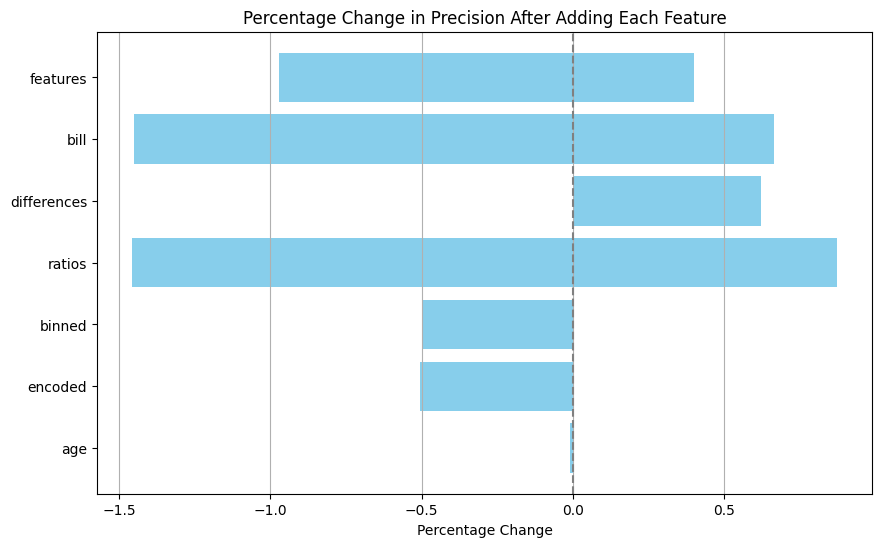

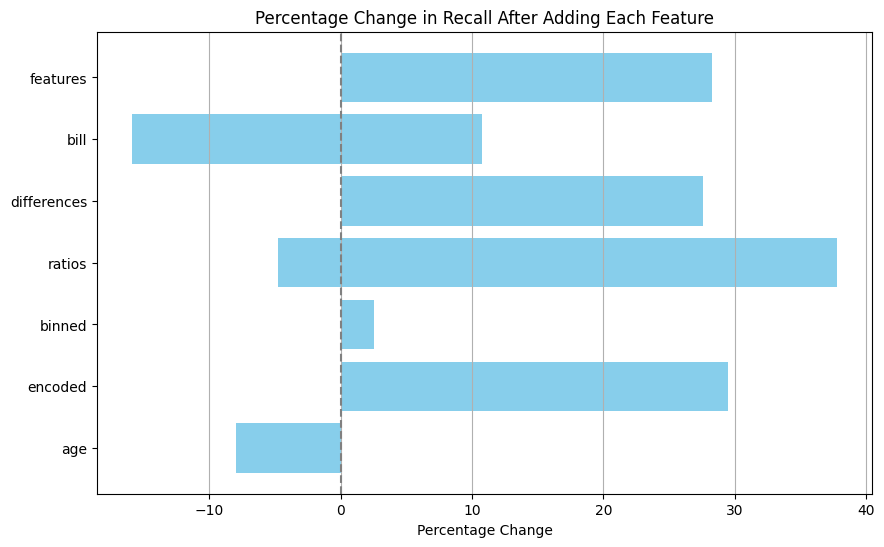

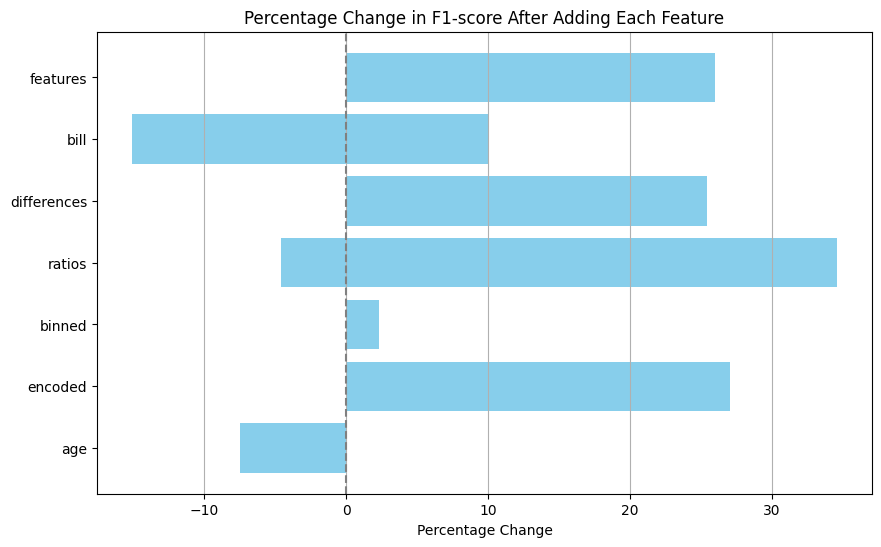

In [15]:
plot_metric_changes(all_comparisons_df, 'precision')
plot_metric_changes(all_comparisons_df, 'recall')
plot_metric_changes(all_comparisons_df, 'f1-score')

In [27]:
# Convert incremental_results to DataFrame
incremental_results_df = results_to_dataframe(incremental_results)
# Display the DataFrame
incremental_results_df.head()
# Optional: Save the DataFrame to a CSV file for further analysis
incremental_results_df.to_csv("incremental_results.csv", index=False)

# Convert the index to a column for presentation
incremental_results_df_reset = incremental_results_df.reset_index()
# Display the specified columns along with the index
incremental_results_df_reset[['index', '1.0_recall', '1.0_f1-score', 'macro avg_f1-score']]

,index,1.0_recall,1.0_f1-score,macro avg_f1-score
0,0,0.990957,0.374377,0.245480
1,1,0.985682,0.379130,0.269565
2,2,0.988696,0.375447,0.252182
3,3,0.987189,0.373752,0.246996
4,4,0.990203,0.378293,0.261777
5,5,0.989450,0.381742,0.275620
6,6,0.989450,0.379974,0.268981
7,7,0.987943,0.378300,0.264116
8,8,0.990957,0.377548,0.258103
9,9,0.988696,0.379849,0.269265


Let's analyze the results, focusing on recall for class 1 (`1.0_recall`) as the priority, while also aiming for a high F1-score for balance.

### Key Metrics to Analyze

- **Recall for Class 1 (Default)** (`1.0_recall`)
- **F1-Score for Class 1 (Default)** (`1.0_f1-score`)
- **Macro Average F1-Score** (`macro avg_f1-score`)

### Interpretation

1. **Highest Recall for Class 1:**
   - Several features achieve very high recall values (near 0.99), which is excellent for identifying defaults. These include:
     - `limit_bal_age` (0.990957)
     - `pay_to_limit_ratios` (0.990203)
     - `average_payment_and_bill` (0.990957)

2. **Best F1-Score for Class 1:**
   - The feature with the highest F1-score for class 1 is `bill_to_limit_ratios` (0.381742), followed closely by `lagged_payment_differences` (0.379974).

3. **Best Macro Average F1-Score:**
   - The highest macro average F1-score is achieved by `bill_to_limit_ratios` (0.275620), indicating a good balance between the classes.

### Recommendations

Given your priority on recall for class 1 and the importance of a balanced F1-score, here are the features that stand out:

1. **Primary Feature:**
   - **`bill_to_limit_ratios`**: This feature achieves the best balance with high recall for class 1 (0.989450) and the highest F1-score for class 1 (0.381742), as well as the highest macro average F1-score (0.275620).

2. **Secondary Features:**
   - **`pay_to_limit_ratios`**: High recall (0.990203) and a good F1-score for class 1 (0.378293).
   - **`payment_timeliness_features`**: Good recall (0.988696) and a balanced F1-score for class 1 (0.379849).
   - **`lagged_payment_differences`**: High recall (0.989450) and a strong F1-score for class 1 (0.379974).

3. **Additional Consideration:**
   - **`target_encoded`**: Despite slightly lower recall (0.985682), it provides a decent balance with a good F1-score for class 1 (0.379130) and a higher macro average F1-score (0.269565).

### Conclusion

To achieve a balance between high recall for class 1 and a balanced F1-score, start with `bill_to_limit_ratios` as the primary feature. Supplement with `pay_to_limit_ratios`, `payment_timeliness_features`, and `lagged_payment_differences` for additional improvements in model performance.

### F1 & F1 Macro Defined

The difference between the F1-score and the F1 macro score lies in how they are calculated and aggregated across multiple classes:

### F1-Score (Per Class)

The F1-score is the harmonic mean of precision and recall for a specific class. It is calculated as follows:

\[ \text{F1-score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}} \]

- **Precision**: The number of true positive results divided by the number of all positive results, including those not correctly identified (i.e., the number of true positives divided by the number of true positives plus the number of false positives).
- **Recall**: The number of true positive results divided by the number of positives that should have been identified (i.e., the number of true positives divided by the number of true positives plus the number of false negatives).

This F1-score is computed separately for each class.

### F1 Macro Score

The F1 macro score is the average of the F1-scores of each class, without considering the proportion of each class in the dataset. It is calculated as follows:

1. Calculate the F1-score for each class.
2. Compute the average of these F1-scores.

\[ \text{F1 macro} = \frac{1}{N} \sum_{i=1}^{N} \text{F1-score}_i \]

where \( N \) is the number of classes.

### Key Differences

1. **Aggregation Method**:
   - **F1-Score (Per Class)**: Measures the balance between precision and recall for a specific class.
   - **F1 Macro**: Takes the unweighted mean of F1-scores for each class, treating all classes equally regardless of their frequency.

2. **Class Proportions**:
   - **F1-Score (Per Class)**: Focuses on a specific class and does not consider the distribution of other classes.
   - **F1 Macro**: Does not take into account the class distribution; thus, each class contributes equally to the final score, making it useful for assessing the performance of models on imbalanced datasets.

3. **Usage Context**:
   - **F1-Score (Per Class)**: Useful when the performance on a specific class is of interest.
   - **F1 Macro**: Useful for overall model evaluation, especially when dealing with imbalanced datasets, as it ensures that the model performs well across all classes rather than being biased towards the majority class.

### Example

Consider a binary classification problem with classes 0 and 1. After evaluating the model, you get the following F1-scores:

- F1-score for class 0: 0.9
- F1-score for class 1: 0.7

The F1 macro score would be the average of these two F1-scores:

\[ \text{F1 macro} = \frac{1}{2} (0.9 + 0.7) = 0.8 \]

This F1 macro score reflects the overall performance across both classes, giving equal importance to each class regardless of its prevalence in the dataset.

#### Increased Performance due to Optimal Weights and Threshold

The dramatic increase in performance when using the optimal weights and threshold can be attributed to several factors that significantly affect the classification model, especially in cases of class imbalance. Here are some key reasons:

1. **Class Imbalance Handling**:
    - **Class Weights**: Assigning higher weights to the minority class (in this case, the default class) ensures that the model pays more attention to correctly predicting the minority class. This helps in improving recall for the minority class, as the model is penalized more for misclassifying these instances.
    - **Threshold Adjustment**: Lowering the decision threshold means that the model will classify more instances as the minority class. This is particularly important when recall is a priority, as it reduces the number of false negatives (missed defaults).

2. **Impact of Proper Weighting and Threshold**:
    - **Recall Improvement**: The primary goal of adjusting weights and thresholds is to capture as many instances of the minority class as possible. This directly boosts recall, as more true positives are identified.
    - **Precision and F1-Score**: While recall improves, the threshold adjustment and proper weighting also help in achieving a balance between precision and recall, leading to a higher F1-score. The F1-score, being the harmonic mean of precision and recall, reflects this balance.

3. **Model Sensitivity**:
    - **Neural Networks**: Neural networks, such as the one used in your model, can be very sensitive to the loss function and class weights. Proper weighting can significantly impact how the network learns, leading to better performance on the minority class.
    - **Learning Dynamics**: With the optimal weights, the model's learning dynamics change, allowing it to better distinguish between the classes during training. This leads to a more effective decision boundary that is better at identifying the minority class.

4. **Synergy with Feature Engineering**:
    - **Complementary Effects**: Feature engineering introduces new informative features, which combined with optimal weights and threshold, can significantly enhance the model's performance. The model can leverage these features more effectively when it's correctly weighted and thresholded.

5. **Evaluation Metrics**:
    - **More Accurate Reflection**: With the correct weights and threshold, the evaluation metrics (precision, recall, F1-score) provide a more accurate reflection of the model's true performance, especially in handling imbalanced data.

### Summary

The combination of optimal weights and threshold dramatically improves the model's ability to correctly classify the minority class (defaults) by:
- Ensuring the model gives more importance to minority class instances.
- Adjusting the decision boundary to favor recall, thereby reducing false negatives.
- Allowing the model to leverage the engineered features more effectively.

These changes lead to a substantial increase in recall and overall model performance metrics, highlighting the importance of proper class imbalance handling in classification tasks.

#### Write Model Pipeline Script

In [12]:
script_content = """
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load the dataset from a URL
def load_data_from_url(url):
    df = pd.read_excel(url, header=1)
    return df

# Clean column names
def clean_column_names(df):
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    return df

# Remove the 'id' column
def remove_id_column(df):
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
    return df

# Rename columns (pay_0 not in dataset)
def rename_columns(df):
    rename_dict = {
        'pay_0': 'pay_1'
    }
    df = df.rename(columns=rename_dict)
    return df

# Convert specified columns to categorical type
def convert_categorical(df, categorical_columns):
    df[categorical_columns] = df[categorical_columns].astype('category')
    return df

# Split the data into training and testing sets
def split_data(df, target):
    X = df.drop(columns=[target])
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    return X_train, X_test, y_train, y_test

# Define the preprocessor
def define_preprocessor(X_train):
    numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    return preprocessor

# Preprocess the data
def preprocess_data(preprocessor, X_train, X_test):
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    return X_train_processed, X_test_processed

# Calculate class weights for imbalanced datasets
def calculate_class_weights(y_train):
    return len(y_train) / (2 * np.bincount(y_train))

# Convert data to PyTorch tensors
def convert_to_tensors(X_train_processed, y_train, X_test_processed, y_test):
    X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)
    return X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor

class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class SklearnSimpleNN(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, learning_rate=0.001, epochs=50, batch_size=64,
                 pos_weight=1.0, threshold=0.5):
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.pos_weight = pos_weight
        self.threshold = threshold
        self.model = SimpleNN(self.input_dim)

    def fit(self, X, y):
        criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(self.pos_weight, dtype=torch.float32))
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        train_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(1))
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.epochs):
            self.model.train()
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, targets.view(-1, 1))
                loss.backward()
                optimizer.step()
        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            if isinstance(X, np.ndarray):
                X = torch.tensor(X, dtype=torch.float32)
            elif isinstance(X, pd.DataFrame):
                X = torch.tensor(X.values, dtype=torch.float32)
            outputs = self.model(X)
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > self.threshold).float()
        return predictions.numpy().squeeze()

# Train the Model
def train_model(nn_estimator, X_train_tensor, y_train_tensor):
    nn_estimator.fit(X_train_tensor.numpy(), y_train_tensor.numpy())
    return nn_estimator

# Evaluate the Model
def evaluate_model(nn_estimator, X_test_tensor, y_test_tensor, label=""):
    y_pred = nn_estimator.predict(X_test_tensor.numpy())
    report = classification_report(y_test_tensor.numpy(), y_pred, output_dict=True)
    print(f"Classification Report ({label}):")
    print(classification_report(y_test_tensor.numpy(), y_pred))
    return report

# Function to run the full pipeline with resampling
def run_full_pipeline_with_resampling(url, categorical_columns, target, resampling_method=None):
    data = load_data_from_url(url)
    data = clean_column_names(data)
    data = rename_columns(data)
    data = remove_id_column(data)
    data = convert_categorical(data, categorical_columns=categorical_columns)
    X_train, X_test, y_train, y_test = split_data(data, target=target)
    preprocessor = define_preprocessor(X_train)

    if resampling_method:
        resampling_pipeline = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('resampler', resampling_method)
        ])
        X_train_processed, y_train = resampling_pipeline.fit_resample(X_train, y_train)
        X_test_processed = preprocessor.transform(X_test)
    else:
        X_train_processed, X_test_processed = preprocess_data(preprocessor, X_train, X_test)

    class_weights = calculate_class_weights(y_train)

    X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = convert_to_tensors(
        X_train_processed, y_train, X_test_processed, y_test)

    nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=class_weights[1])
    nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)
    evaluate_model(nn_estimator, X_test_tensor, y_test_tensor)

if __name__ == "__main__":
    import argparse

    parser = argparse.ArgumentParser(description="Run full pipeline with resampling")
    parser.add_argument("url", type=str, help="URL of the dataset")
    parser.add_argument("categorical_columns", type=str, nargs="+", help="List of categorical columns")
    parser.add_argument("target", type=str, help="Target column")
    parser.add_argument("--resampling", type=str, choices=['smote', 'oversample', 'undersample'], help="Resampling method")

    args = parser.parse_args()

    if args.resampling == 'smote':
        resampling_method = SMOTE(random_state=42)
    elif args.resampling == 'oversample':
        resampling_method = RandomOverSampler(random_state=42)
    elif args.resampling == 'undersample':
        resampling_method = RandomUnderSampler(random_state=42)
    else:
        resampling_method = None

    run_full_pipeline_with_resampling(args.url, args.categorical_columns, args.target, resampling_method)
"""

# write script
with open("model_pipeline.py", "w") as file:
    file.write(script_content)

print("Function appended successfully to model_pipeline.py")

# reload script to make function available for use
import importlib
import model_pipeline
importlib.reload(model_pipeline)

from model_pipeline import (
    load_data_from_url, clean_column_names, rename_columns, remove_id_column,
    convert_categorical, split_data, define_preprocessor, preprocess_data,
    calculate_class_weights, convert_to_tensors, SklearnSimpleNN, train_model, evaluate_model
)


Function appended successfully to model_pipeline.py


#### Write Feature Engineering Script

In [10]:
# Function to write script
script_content = """
import pandas as pd
import numpy as np
import torch
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import classification_report
from model_pipeline import load_data_from_url, clean_column_names, remove_id_column, convert_categorical, split_data, train_model, calculate_class_weights, convert_to_tensors, preprocess_data, define_preprocessor, SimpleNN, SklearnSimpleNN
import matplotlib.pyplot as plt

# Rename columns (pay_0 not in dataset)
def rename_columns(df):
    rename_dict = {
        'pay_0': 'pay_1'
    }
    df = df.rename(columns=rename_dict)
    return df

# Apply feature engineering to the entire dataset
def create_interaction_features(df):
    df['limit_bal_age'] = df['limit_bal'] * df['age']
    return df

def target_encode(df, target, categorical_columns):
    for col in categorical_columns:
        mean_target = df.groupby(col)[target].mean()
        df[col + '_target_enc'] = df[col].map(mean_target)
    return df

def bin_features(df, column, bins):
    df[column + '_binned'] = pd.cut(df[column], bins=bins)
    return df

def create_payment_to_bill_ratios(df):
    for i in range(1, 7):
        df[f'pay_to_bill_ratio_{i}'] = df[f'pay_amt{i}'] / df[f'bill_amt{i}'].replace(0, np.nan)
    return df

def create_payment_to_limit_ratios(df):
    for i in range(1, 7):
        df[f'pay_to_limit_ratio_{i}'] = df[f'pay_amt{i}'] / df['limit_bal']
    return df

def create_bill_to_limit_ratios(df):
    for i in range(1, 7):
        df[f'bill_to_limit_ratio_{i}'] = df[f'bill_amt{i}'] / df['limit_bal']
    return df

def create_lagged_payment_differences(df):
    for i in range(1, 6):
        df[f'pay_amt_diff_{i}'] = df[f'pay_amt{i+1}'] - df[f'pay_amt{i}']
    return df

def create_debt_ratio_features(df):
    for i in range(1, 7):
        df[f'debt_ratio_{i}'] = df[f'bill_amt{i}'] / df['limit_bal']
    return df

def create_average_payment_and_bill(df):
    df['avg_payment'] = df[[f'pay_amt{i}' for i in range(1, 7)]].mean(axis=1)
    df['avg_bill'] = df[[f'bill_amt{i}' for i in range(1, 7)]].mean(axis=1)
    return df

def create_payment_timeliness_features(df):
    for i in range(1, 7):
        df[f'pay_on_time_{i}'] = (df[f'pay_{i}'] <= 0).astype(int)
    return df

def create_total_payment_and_bill(df):
    df['total_payment'] = df[[f'pay_amt{i}' for i in range(1, 7)]].sum(axis=1)
    df['total_bill'] = df[[f'bill_amt{i}' for i in range(1, 7)]].sum(axis=1)
    return df

def create_bill_difference_features(df):
    for i in range(1, 6):
        df[f'bill_diff_{i}'] = df[f'bill_amt{i+1}'] - df[f'bill_amt{i}']
    return df

# Evaluate the model and save the report before feature engineering
def evaluate_model(nn_estimator, X_test_tensor, y_test_tensor, label):
    y_pred = nn_estimator.predict(X_test_tensor.numpy())
    report = classification_report(y_test_tensor.numpy(), y_pred, output_dict=True)
    print(f"Classification Report ({label}):")
    print(classification_report(y_test_tensor.numpy(), y_pred))
    return report

# Incrementally Add Features and Evaluate
def add_features_incrementally(data, features_to_add, target, pos_weight, threshold):
    results = []

    for feature in features_to_add:
        # Create a copy of the data to avoid modifying the original DataFrame
        data_copy = data.copy()

        # Apply the feature engineering function
        print(f"Adding feature: {feature['name']}")
        data_copy = feature['func'](data_copy)

        # Split the data
        X_train, X_test, y_train, y_test = split_data(data_copy, target=target)

        # Preprocess the data
        preprocessor = define_preprocessor(X_train)
        X_train_processed, X_test_processed = preprocess_data(preprocessor, X_train, X_test)

        # Convert data to tensors
        X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = convert_to_tensors(X_train_processed, y_train, X_test_processed, y_test)

        # Train the model
        nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=pos_weight, threshold=threshold)
        nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)

        # Evaluate the model
        report = evaluate_model(nn_estimator, X_test_tensor, y_test_tensor, label=feature['name'])
        results.append({'feature': feature['name'], 'report': report})

    return results

def compare_classification_reports(report_before, report_after):
    # Convert reports to DataFrame
    report_before_df = pd.DataFrame(report_before).transpose()
    report_after_df = pd.DataFrame(report_after).transpose()

    # Merge reports
    comparison_df = report_before_df.join(report_after_df, lsuffix='_before', rsuffix='_after')

    # Calculate percentage change
    comparison_df['precision_change'] = (comparison_df['precision_after'] - comparison_df['precision_before']) / comparison_df['precision_before'] * 100
    comparison_df['recall_change'] = (comparison_df['recall_after'] - comparison_df['recall_before']) / comparison_df['recall_before'] * 100
    comparison_df['f1-score_change'] = (comparison_df['f1-score_after'] - comparison_df['f1-score_before']) / comparison_df['f1-score_before'] * 100

    # print("Comparison of Classification Report Metrics:")
    # print(comparison_df[['precision_before', 'precision_after', 'precision_change',
    #                      'recall_before', 'recall_after', 'recall_change',
    #                      'f1-score_before', 'f1-score_after', 'f1-score_change']])

    return comparison_df

def compare_incremental_reports(report_baseline, incremental_results):
    # Convert the baseline report to DataFrame
    report_baseline_df = pd.DataFrame(report_baseline).transpose()

    # Initialize a list to store comparison results
    all_comparisons = []

    # Iterate through the incremental results
    for result in incremental_results:
        report_after = result['report']
        feature_name = result['feature']

        # Convert the current report to DataFrame
        report_after_df = pd.DataFrame(report_after).transpose()

        # Merge the baseline and current reports
        comparison_df = report_baseline_df.join(report_after_df, lsuffix='_baseline', rsuffix=f'_{feature_name}')

        # Calculate percentage change
        comparison_df[f'precision_change_{feature_name}'] = (comparison_df[f'precision_{feature_name}'] - comparison_df['precision_baseline']) / comparison_df['precision_baseline'] * 100
        comparison_df[f'recall_change_{feature_name}'] = (comparison_df[f'recall_{feature_name}'] - comparison_df['recall_baseline']) / comparison_df['recall_baseline'] * 100
        comparison_df[f'f1-score_change_{feature_name}'] = (comparison_df[f'f1-score_{feature_name}'] - comparison_df['f1-score_baseline']) / comparison_df['f1-score_baseline'] * 100

        # Add the comparison result to the list
        all_comparisons.append(comparison_df)

    # Concatenate all comparison DataFrames
    all_comparisons_df = pd.concat(all_comparisons, axis=1)

    return all_comparisons_df

def plot_metric_changes(all_comparisons_df, metric):
    # Extract percentage change columns for the specified metric
    change_cols = [col for col in all_comparisons_df.columns if col.startswith(f'{metric}_change')]

    # Extract feature names from the column headers
    feature_names = [col.split('_')[-1] for col in change_cols]

    # Plot the percentage changes
    changes = all_comparisons_df.loc[:, change_cols].iloc[0]  # assuming we want the changes for the first class (or overall if it's a macro/micro average)
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, changes, color='skyblue')
    plt.axvline(x=0, color='gray', linestyle='--')  # Add vertical line at 0
    plt.xlabel('Percentage Change')
    plt.title(f'Percentage Change in {metric.capitalize()} After Adding Each Feature')
    plt.grid(axis='x')
    plt.show()

# Define a function to extract the metrics and convert to DataFrame
def results_to_dataframe(incremental_results):
    # List to hold the structured data
    data = []

    # Iterate over the results
    for result in incremental_results:
        feature_name = result['feature']
        report = result['report']

        # Initialize a dictionary to hold the flattened report
        flattened_report = {'feature': feature_name}

        # Flatten the report dictionary
        for key, subdict in report.items():
            if isinstance(subdict, dict):
                for subkey, value in subdict.items():
                    flattened_report[f"{key}_{subkey}"] = value
            else:
                flattened_report[key] = subdict

        # Append the flattened report to the data list
        data.append(flattened_report)

    # Convert the data list to a DataFrame
    results_df = pd.DataFrame(data)

    return results_df


"""

# Write the functions to feature_engineering.py script
with open("feature_engineering.py", "w") as file:
    file.write(script_content)

print("Functions successfully written to feature_engineering.py")

# reload script to make function available for use
import importlib
import feature_engineering
importlib.reload(feature_engineering)

from feature_engineering import (
    create_interaction_features, create_payment_to_bill_ratios,
    create_payment_to_limit_ratios, create_bill_to_limit_ratios,
    create_lagged_payment_differences, create_debt_ratio_features,
    create_average_payment_and_bill, create_payment_timeliness_features,
    create_total_payment_and_bill, create_bill_difference_features,
    bin_features, target_encode, rename_columns,
    add_features_incrementally, compare_incremental_reports,
    plot_metric_changes
)


Functions successfully written to feature_engineering.py


In [2]:
##### PREVIOUS VERSION ####

# Function to write script
script_content = """

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load the dataset from a URL
def load_data_from_url(url):
    df = pd.read_excel(url, header=1)
    return df

# Clean column names
def clean_column_names(df):
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    return df

# Remove the 'id' column
def remove_id_column(df):
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
    return df

# Rename columns (pay_0 not in dataset)
def rename_columns(df):
    rename_dict = {
        'pay_0': 'pay_1'
    }
    df = df.rename(columns=rename_dict)
    return df

# Convert specified columns to categorical type
def convert_categorical(df, categorical_columns):
    df[categorical_columns] = df[categorical_columns].astype('category')
    return df

# Split the data into training and testing sets
def split_data(df, target):
    X = df.drop(columns=[target])
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    return X_train, X_test, y_train, y_test

# Define the preprocessor
def define_preprocessor(X_train):
    numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    return preprocessor

# Preprocess the data
def preprocess_data(preprocessor, X_train, X_test):
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    return X_train_processed, X_test_processed

# Calculate class weights for imbalanced datasets
def calculate_class_weights(y_train):
    return len(y_train) / (2 * np.bincount(y_train))

# Convert data to PyTorch tensors
def convert_to_tensors(X_train_processed, y_train, X_test_processed, y_test):
    X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)
    return X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor

class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class SklearnSimpleNN(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, learning_rate=0.001, epochs=50, batch_size=64,
                 pos_weight=1.0, threshold=0.5):
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.pos_weight = pos_weight
        self.threshold = threshold
        self.model = SimpleNN(self.input_dim)

    def fit(self, X, y):
        criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(self.pos_weight, dtype=torch.float32))
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        train_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(1))
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.epochs):
            self.model.train()
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, targets.view(-1, 1))
                loss.backward()
                optimizer.step()
        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            if isinstance(X, np.ndarray):
                X = torch.tensor(X, dtype=torch.float32)
            elif isinstance(X, pd.DataFrame):
                X = torch.tensor(X.values, dtype=torch.float32)
            outputs = self.model(X)
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > self.threshold).float()
        return predictions.numpy().squeeze()

# Train the Model
def train_model(nn_estimator, X_train_tensor, y_train_tensor):
    nn_estimator.fit(X_train_tensor.numpy(), y_train_tensor.numpy())
    return nn_estimator

# Evaluate the Model
def evaluate_model(nn_estimator, X_test_tensor, y_test_tensor, label=""):
    y_pred = nn_estimator.predict(X_test_tensor.numpy())
    report = classification_report(y_test_tensor.numpy(), y_pred, output_dict=True)
    print(f"Classification Report ({label}):")
    print(classification_report(y_test_tensor.numpy(), y_pred))
    return report

# Function to run the full pipeline with resampling
def run_full_pipeline_with_resampling(url, categorical_columns, target, resampling_method=None):
    data = load_data_from_url(url)
    data = clean_column_names(data)
    data = remove_id_column(data)
    data = convert_categorical(data, categorical_columns=categorical_columns)
    X_train, X_test, y_train, y_test = split_data(data, target=target)
    preprocessor = define_preprocessor(X_train)

    if resampling_method:
        resampling_pipeline = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('resampler', resampling_method)
        ])
        X_train_processed, y_train = resampling_pipeline.fit_resample(X_train, y_train)
        X_test_processed = preprocessor.transform(X_test)
    else:
        X_train_processed, X_test_processed = preprocess_data(preprocessor, X_train, X_test)

    class_weights = calculate_class_weights(y_train)

    X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = convert_to_tensors(
        X_train_processed, y_train, X_test_processed, y_test)

    nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=class_weights[1])
    nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)
    evaluate_model(nn_estimator, X_test_tensor, y_test_tensor)

if __name__ == "__main__":
    import argparse

    parser = argparse.ArgumentParser(description="Run full pipeline with resampling")
    parser.add_argument("url", type=str, help="URL of the dataset")
    parser.add_argument("categorical_columns", type=str, nargs="+", help="List of categorical columns")
    parser.add_argument("target", type=str, help="Target column")
    parser.add_argument("--resampling", type=str, choices=['smote', 'oversample', 'undersample'], help="Resampling method")

    args = parser.parse_args()

    if args.resampling == 'smote':
        resampling_method = SMOTE(random_state=42)
    elif args.resampling == 'oversample':
        resampling_method = RandomOverSampler(random_state=42)
    elif args.resampling == 'undersample':
        resampling_method = RandomUnderSampler(random_state=42)
    else:
        resampling_method = None

    run_full_pipeline_with_resampling(args.url, args.categorical_columns, args.target, resampling_method)

"""

# write script
with open("model_pipeline.py", "w") as file:
    file.write(script_content)

print("Function appended successfully to model_pipeline.py")

# reload script to make function available for use
import importlib
import model_pipeline
importlib.reload(model_pipeline)

from model_pipeline import (
    load_data_from_url, clean_column_names, rename_columns, remove_id_column,
    convert_categorical, split_data, define_preprocessor, preprocess_data,
    calculate_class_weights, convert_to_tensors, SklearnSimpleNN, train_model, evaluate_model
)

Function appended successfully to model_pipeline.py


In [9]:
##### PREVOUS VERSION #####
# Function to write script
script_content = """

import pandas as pd
import numpy as np
import torch
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import classification_report
from model_pipeline import load_data_from_url, clean_column_names, remove_id_column, convert_categorical, split_data, train_model, calculate_class_weights, convert_to_tensors, preprocess_data, define_preprocessor, SimpleNN, SklearnSimpleNN
import matplotlib.pyplot as plt

# Rename columns (pay_0 not in dataset)
def rename_columns(df):
    rename_dict = {
        'pay_0': 'pay_1'
    }
    df = df.rename(columns=rename_dict)
    return df

# Apply feature engineering to the entire dataset
def create_interaction_features(df):
    df['limit_bal_age'] = df['limit_bal'] * df['age']
    return df

def target_encode(df, target, categorical_columns):
    for col in categorical_columns:
        mean_target = df.groupby(col)[target].mean()
        df[col + '_target_enc'] = df[col].map(mean_target)
    return df

def bin_features(df, column, bins):
    df[column + '_binned'] = pd.cut(df[column], bins=bins)
    return df

def create_payment_to_bill_ratios(df):
    for i in range(1, 7):
        df[f'pay_to_bill_ratio_{i}'] = df[f'pay_amt{i}'] / df[f'bill_amt{i}'].replace(0, np.nan)
    return df

def create_payment_to_limit_ratios(df):
    for i in range(1, 7):
        df[f'pay_to_limit_ratio_{i}'] = df[f'pay_amt{i}'] / df['limit_bal']
    return df

def create_bill_to_limit_ratios(df):
    for i in range(1, 7):
        df[f'bill_to_limit_ratio_{i}'] = df[f'bill_amt{i}'] / df['limit_bal']
    return df

def create_lagged_payment_differences(df):
    for i in range(1, 6):
        df[f'pay_amt_diff_{i}'] = df[f'pay_amt{i+1}'] - df[f'pay_amt{i}']
    return df

def create_debt_ratio_features(df):
    for i in range(1, 7):
        df[f'debt_ratio_{i}'] = df[f'bill_amt{i}'] / df['limit_bal']
    return df

def create_average_payment_and_bill(df):
    df['avg_payment'] = df[[f'pay_amt{i}' for i in range(1, 7)]].mean(axis=1)
    df['avg_bill'] = df[[f'bill_amt{i}' for i in range(1, 7)]].mean(axis=1)
    return df

def create_payment_timeliness_features(df):
    for i in range(1, 7):
        df[f'pay_on_time_{i}'] = (df[f'pay_{i}'] <= 0).astype(int)
    return df

def create_total_payment_and_bill(df):
    df['total_payment'] = df[[f'pay_amt{i}' for i in range(1, 7)]].sum(axis=1)
    df['total_bill'] = df[[f'bill_amt{i}' for i in range(1, 7)]].sum(axis=1)
    return df

def create_bill_difference_features(df):
    for i in range(1, 6):
        df[f'bill_diff_{i}'] = df[f'bill_amt{i+1}'] - df[f'bill_amt{i}']
    return df

# Evaluate the model and save the report before feature engineering
def evaluate_model(nn_estimator, X_test_tensor, y_test_tensor, label):
    y_pred = nn_estimator.predict(X_test_tensor.numpy())
    report = classification_report(y_test_tensor.numpy(), y_pred, output_dict=True)
    # print(f"Classification Report ({label}):")
    # print(classification_report(y_test_tensor.numpy(), y_pred))
    return report

def compare_classification_reports(report_before, report_after):
    # Convert reports to DataFrame
    report_before_df = pd.DataFrame(report_before).transpose()
    report_after_df = pd.DataFrame(report_after).transpose()

    # Merge reports
    comparison_df = report_before_df.join(report_after_df, lsuffix='_before', rsuffix='_after')

    # Calculate percentage change
    comparison_df['precision_change'] = (comparison_df['precision_after'] - comparison_df['precision_before']) / comparison_df['precision_before'] * 100
    comparison_df['recall_change'] = (comparison_df['recall_after'] - comparison_df['recall_before']) / comparison_df['recall_before'] * 100
    comparison_df['f1-score_change'] = (comparison_df['f1-score_after'] - comparison_df['f1-score_before']) / comparison_df['f1-score_before'] * 100

    print("Comparison of Classification Report Metrics:")
    print(comparison_df[['precision_before', 'precision_after', 'precision_change',
                         'recall_before', 'recall_after', 'recall_change',
                         'f1-score_before', 'f1-score_after', 'f1-score_change']])

    return comparison_df

# Incrementally Add Features and Evaluate
def add_features_incrementally(data, features_to_add, target, pos_weight, threshold):
    results = []

    for feature in features_to_add:
        # Create a copy of the data to avoid modifying the original DataFrame
        data_copy = data.copy()

        # Apply the feature engineering function
        print(f"Adding feature: {feature['name']}")
        data_copy = feature['func'](data_copy)

        # Split the data
        X_train, X_test, y_train, y_test = split_data(data_copy, target=target)

        # Preprocess the data
        preprocessor = define_preprocessor(X_train)
        X_train_processed, X_test_processed = preprocess_data(preprocessor, X_train, X_test)

        # Convert data to tensors
        X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = convert_to_tensors(X_train_processed, y_train, X_test_processed, y_test)

        # Train the model
        nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=pos_weight, threshold=threshold)
        nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)

        # Evaluate the model
        report = evaluate_model(nn_estimator, X_test_tensor, y_test_tensor, label=feature['name'])
        results.append({'feature': feature['name'], 'report': report})

    return results

def compare_classification_reports(report_before, report_after):
    # Convert reports to DataFrame
    report_before_df = pd.DataFrame(report_before).transpose()
    report_after_df = pd.DataFrame(report_after).transpose()

    # Merge reports
    comparison_df = report_before_df.join(report_after_df, lsuffix='_before', rsuffix='_after')

    # Calculate percentage change
    comparison_df['precision_change'] = (comparison_df['precision_after'] - comparison_df['precision_before']) / comparison_df['precision_before'] * 100
    comparison_df['recall_change'] = (comparison_df['recall_after'] - comparison_df['recall_before']) / comparison_df['recall_before'] * 100
    comparison_df['f1-score_change'] = (comparison_df['f1-score_after'] - comparison_df['f1-score_before']) / comparison_df['f1-score_before'] * 100

    print("Comparison of Classification Report Metrics:")
    print(comparison_df[['precision_before', 'precision_after', 'precision_change',
                         'recall_before', 'recall_after', 'recall_change',
                         'f1-score_before', 'f1-score_after', 'f1-score_change']])

    return comparison_df

def compare_incremental_reports(report_baseline, incremental_results):
    # Convert the baseline report to DataFrame
    report_baseline_df = pd.DataFrame(report_baseline).transpose()

    # Initialize a list to store comparison results
    all_comparisons = []

    # Iterate through the incremental results
    for result in incremental_results:
        report_after = result['report']
        feature_name = result['feature']

        # Convert the current report to DataFrame
        report_after_df = pd.DataFrame(report_after).transpose()

        # Merge the baseline and current reports
        comparison_df = report_baseline_df.join(report_after_df, lsuffix='_baseline', rsuffix=f'_{feature_name}')

        # Calculate percentage change
        comparison_df[f'precision_change_{feature_name}'] = (comparison_df[f'precision_{feature_name}'] - comparison_df['precision_baseline']) / comparison_df['precision_baseline'] * 100
        comparison_df[f'recall_change_{feature_name}'] = (comparison_df[f'recall_{feature_name}'] - comparison_df['recall_baseline']) / comparison_df['recall_baseline'] * 100
        comparison_df[f'f1-score_change_{feature_name}'] = (comparison_df[f'f1-score_{feature_name}'] - comparison_df['f1-score_baseline']) / comparison_df['f1-score_baseline'] * 100

        # Add the comparison result to the list
        all_comparisons.append(comparison_df)

    # Concatenate all comparison DataFrames
    all_comparisons_df = pd.concat(all_comparisons, axis=1)

    return all_comparisons_df


def plot_metric_changes(all_comparisons_df, metric):
    # Extract percentage change columns for the specified metric
    change_cols = [col for col in all_comparisons_df.columns if col.startswith(f'{metric}_change')]

    # Extract feature names from the column headers
    feature_names = [col.split('_')[-1] for col in change_cols]

    # Plot the percentage changes
    changes = all_comparisons_df.loc[:, change_cols].iloc[0]  # assuming we want the changes for the first class (or overall if it's a macro/micro average)
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, changes, color='skyblue')
    plt.axvline(x=0, color='gray', linestyle='--')  # Add vertical line at 0
    plt.xlabel('Percentage Change')
    plt.title(f'Percentage Change in {metric.capitalize()} After Adding Each Feature')
    plt.grid(axis='x')
    plt.show()

"""

# Write the functions to feature_engineering.py script
with open("feature_engineering.py", "w") as file:
    file.write(script_content)

print("Functions successfully written to feature_engineering.py")

# reload script to make function available for use
import importlib
import feature_engineering
importlib.reload(feature_engineering)

from feature_engineering import (
    create_interaction_features, create_payment_to_bill_ratios,
    create_payment_to_limit_ratios, create_bill_to_limit_ratios,
    create_lagged_payment_differences, create_debt_ratio_features,
    create_average_payment_and_bill, create_payment_timeliness_features,
    create_total_payment_and_bill, create_bill_difference_features,
    bin_features, target_encode, rename_columns,
    add_features_incrementally, compare_incremental_reports,
    plot_metric_changes
)

Functions successfully written to feature_engineering.py
